In [57]:
# Importing libraries
from random import sample
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 200)
%matplotlib inline

In [58]:
# Loading the dataset
data = pd.read_csv('training_v2.csv')

## Data Preprocessing
### Class Imbalance
We find that this dataset is hugely imbalanced. There are very few observations of `hospital_death` = 1 as compared to `hospital_death` = 0. Once presented with previously unseen data, this can prove to be a problem since classification algorithms might classify all the entries as `hospital_death` = 0 in order to obtain a high accuracy. 

In [59]:
# Extracting the counts for each level of the target feature
data['hospital_death'].value_counts()

0    83798
1     7915
Name: hospital_death, dtype: int64

### Resampling 

Resampling, as the name suggests, allows us to obtain a different sample of the data so as to ensure that both classes in our target variable are evenly distributed. Since we have almost 100,000 records in the dataset, we choose **downsampling technique** so that our dataset is reduced to something more manageable thereby also speeding up our first iteration of modeling. 

In [60]:
# Extracting the rows where hospital == 0
alive_data = data[data['hospital_death'] == 0].reset_index(drop=True)

# Generating indexes from 0 to 83798
idx = list(range(0,83798))

# Subset a sample without replacement from the indexes
random.seed(42)
subset = sample(idx, 7915)

# Subsetting the alive_data with the chosen indexes, reseting the index
alive_data = alive_data.loc[subset].reset_index(drop=True)

In [61]:
# Appending the alive_data with the observations where hospital_death == 1
new_data = alive_data.append(data[data['hospital_death'] == 1])

# Shuffling the dataset so the distribution of 0 and 1 is random throughout the dataset
new_data = new_data.sample(frac=1).reset_index(drop=True)

In [62]:
new_data.shape

(15830, 186)

In [63]:
new_data.head(20)

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,icu_id,icu_stay_type,icu_type,pre_icu_los_days,readmission_status,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,88430,2187,171,0,63.0,27.202216,1,Caucasian,M,190.0,PACU,Operating Room / Recovery,404,admit,CSICU,0.144444,0,98.2,NaN,202.0,1204.01,1,0.0,NaN,11.0,0.78,NaN,4.0,6.0,0.0,5.0,106.0,109.0,36.9,0.0,134.0,NaN,NaN,NaN,NaN,28.0,137.0,36.30,NaN,0.0,7.50,87.0,57.0,90.0,71.0,90.0,71.0,106.0,79.0,113.0,73.0,101.0,82.0,101.0,82.0,26.0,13.0,98.0,91.0,168.0,106.0,143.0,122.0,143.0,122.00,38.20,36.300,87.0,72.0,90.0,77.0,90.0,77.0,83.0,79.0,113.0,94.0,101.0,88.0,101.0,88.0,19.0,17.0,98.0,94.0,168.0,144.0,143.0,123.0,143.0,123.0,36.30,36.30,NaN,NaN,NaN,NaN,11.0,11.0,8.1,8.1,0.78,0.78,106.0,106.0,23.0,23.0,12.2,12.2,36.9,36.9,NaN,NaN,NaN,NaN,171.0,171.0,3.8,3.8,137.0,137.0,7.50,7.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
1,79169,67579,19,1,76.0,38.402118,0,Caucasian,M,177

### Split the feature variables and the target variable

In [64]:
X = new_data.drop('hospital_death', axis = 1)
y = new_data['hospital_death']
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15830 entries, 0 to 15829
Columns: 185 entries, encounter_id to apache_2_bodysystem
dtypes: float64(170), int64(7), object(8)
memory usage: 22.3+ MB


### Missing values
This dataset contains a lot of missing values and we've employed various strategies throughout the notebook to deal with them. We first start with: 
1. **Drop rows that contain missing values greater than a 50% threshold.**
2. **Use the index of the rows in step 1 to drop the respective values from the target variable column.**

In [65]:
# Look at the row-wise percentage of missing values in X
X.isnull().mean(axis = 1)

0        0.335135
1        0.335135
2        0.394595
3        0.345946
4        0.486486
5        0.437838
6        0.578378
7        0.254054
8        0.405405
9        0.400000
10       0.432432
11       0.518919
12       0.286486
13       0.389189
14       0.102703
15       0.345946
16       0.302703
17       0.302703
18       0.367568
19       0.221622
20       0.329730
21       0.108108
22       0.372973
23       0.286486
24       0.118919
25       0.248649
26       0.145946
27       0.524324
28       0.394595
29       0.470270
           ...   
15800    0.535135
15801    0.167568
15802    0.275676
15803    0.551351
15804    0.091892
15805    0.432432
15806    0.259459
15807    0.340541
15808    0.545946
15809    0.264865
15810    0.308108
15811    0.351351
15812    0.210811
15813    0.324324
15814    0.162162
15815    0.421622
15816    0.243243
15817    0.037838
15818    0.351351
15819    0.189189
15820    0.254054
15821    0.529730
15822    0.394595
15823    0.378378
15824    0

In [66]:
# Obtaining the index values of rows where 50% or more of the data is missing
idx = X.index[X.isnull().mean(axis=1) > 0.5].tolist()

# Dropping rows from X
row_majority_X = X.drop(X.index[idx]).reset_index(drop=True)
print("The shape of X after dropping rows is {}".format(row_majority_X.shape))

# Dropping corresponding rows from y
final_y = y.drop(y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X after dropping rows is (14636, 185)
The shape of y after dropping rows is (14636,)


### Feature Selection

We follow 2 strategies in order to reduce the number of dimensions in our dataset.
1. **Drop columns that contain missing values greater than a 75% threshold:**
> For example, the column `h1_pao2fio2ratio_min` is missing 83.5% of its data. 
2. **Drop coloumns based on manual evaluation of the data:**
> For example, drop the `id` columns since they don't provide any relevant information in predicting `hospital_death`.
> Drop the `height` and `weight` columns since they are collinear to the `bmi` column.
> Drop the `readmission_status` column since it contains all 0s. 

In [67]:
# Look at the column-wise percentage of missing values in X
row_majority_X.isnull().mean()

encounter_id                     0.000000
patient_id                       0.000000
hospital_id                      0.000000
age                              0.055411
bmi                              0.037442
elective_surgery                 0.000000
ethnicity                        0.013870
gender                           0.000410
height                           0.015646
hospital_admit_source            0.223968
icu_admit_source                 0.001093
icu_id                           0.000000
icu_stay_type                    0.000000
icu_type                         0.000000
pre_icu_los_days                 0.000000
readmission_status               0.000000
weight                           0.027603
albumin_apache                   0.503895
apache_2_diagnosis               0.010180
apache_3j_diagnosis              0.006901
apache_post_operative            0.000000
arf_apache                       0.004031
bilirubin_apache                 0.552952
bun_apache                       0

In [68]:
# Retain only those columns where missing values are less than 75%
column_majority_X = row_majority_X[row_majority_X.columns[row_majority_X.isnull().mean() < 0.75]]
column_majority_X.shape

(14636, 149)

In [69]:
# Drop columns based on manual evaluation of data
final_X = column_majority_X.drop(columns=['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'height', 'weight', 'readmission_status'], axis=1)
print("The shape of X after dropping columns is {}".format(final_X.shape))

The shape of X after dropping columns is (14636, 142)


### Feature Transformation
1. **Transforming `BMI` from a numerical to a categorical variable**

BMI Categories | BMI Values
--- | ---
Underweight | <18.5 =0
Normal weight | 18.5–24.9 =1
Overweight | 25–29.9 =2
Obesity | BMI of 30 or greater =3

2. **Transforming `pre_icu_los_days` from a numerical to a categorical variable**

pre_icu_los_days Categories | pre_icu_los_days Values
--- | ---
'0' | <= 0
'1' | > 0 and <= 5
'2' | > 5 and <= 10
'3' | > 10 and <= 15
'4' | > 15 and <= 20
'5' | > 20 and <= 25
'6' | > 25 and <= 30
'7' | => 30

In [20]:
# Transforming BMI to a categorical variable
def BMICat(x) :
    try :
         x = float(x)
         if (x >= 0) and (x < 18.5) : return 'Underweight'
         elif ((x >= 18.5 ) and (x <= 24.9)) : return 'Normal Weight'
         elif ((x >= 25 )   and (x <= 29.9)) : return 'Overweight'
         else : return 'Obese'
    except ValueError:
         return 'Other'

final_X['bmi'] = final_X['bmi'].apply(BMICat)

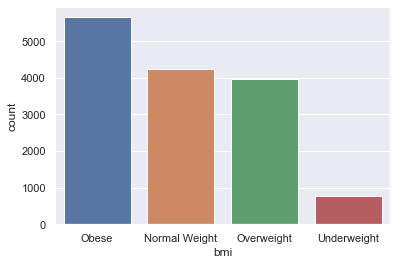

In [28]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['bmi'], order = final_X['bmi'].value_counts().index)
plt.show()

In [24]:
# Transforming pre_icu_los_days to a categorical variable
def PILDCat(x) :
    try :
         x = float(x)
         if (x <= 0)                : return 'Range[- to 0]'
         elif (x > 0) and (x <= 5) : return  'Range[1 to 5]'
         elif (x > 5) and (x <= 10) : return 'Range[5 to 10]'
         elif (x > 10) and (x <= 15) : return 'Range[11 to 15]'
         elif ((x > 15) and (x <= 20)) : return 'Range[16 to 20]'
         elif ((x > 20) and (x <= 25)) : return 'Range[21 to 25]'
         elif ((x > 25 ) and (x <= 30)) : return 'Range[25 to 30]'
               
         else : return 'Range[> 30]'
    except ValueError:
         return 'Other'

final_X['pre_icu_los_days']= final_X['pre_icu_los_days'].apply(PILDCat)

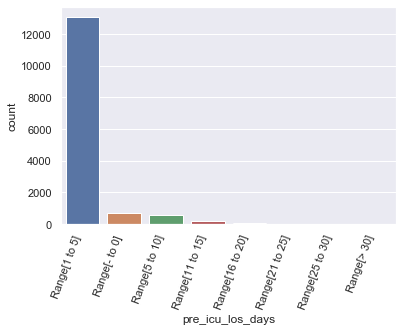

In [27]:
sns.set(style="darkgrid")
ax = sns.countplot(final_X['pre_icu_los_days'], order = final_X['pre_icu_los_days'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

### Split categorical and numerical variables

In [29]:
def num_cat_col(df):
    '''
    Splits the columns of the dataframe into categorical and numerical columns 
    and returns them as 2 separate lists.
    Columns having binary values (0 or 1) are added to the list of categorical columns.
    '''
    num_col = []
    cat_col = []
    dictionary = pd.read_csv('WiDS Datathon 2020 Dictionary.csv')
    new_dictionary = dictionary[dictionary['Data Type'] == 'binary']
    
    for column in df.columns:
        if df[column].dtypes == 'object':
            cat_col.append(column)
        elif column in [value for key, value in new_dictionary['Variable Name'].iteritems()]:
            cat_col.append(column)
        else:
            num_col.append(column)
    return cat_col, num_col

cat_col, num_col = num_cat_col(final_X)

### Dealing with categorical variables

There are still some missing values that need to be taken care of among our categorical variables so we evaluate them in order:
1. **ethnicity** 
> Impute the missing values with 'Other/Unknown' since the dataframe already has that value.
2. **gender** 
> We observe that there are only 6 missing values. Therefore, we decide to impute values as either 'M' or 'F' based on the percentage of these 2 classes in the column. Following that, we encode the values as follows:

Value | Encoding
--- | ---
'F' | 0
'M' | 1

3. **hospital_admit_source** and **icu_admit_source**
> On evaluating the 2 columns side by side, we find that `icu_admit_source` is conveying similar information as `hospital_admit_source` and also has fewer missing values than `hospital_admit_source`. Therefore we decide to drop `hospital_admit_source` and impute the missing values of `icu_admit_source` wuth 'Unknown'.
4. **apache_3j_bodysystem** and **apache_2_bodysystem** 
> On evaluating the 2 columns side by side, we find that `apache_3j_bodysystem` is conveying similar information as `apache_2_bodysystem`. Therefore we decide to drop `apache_2_bodysystem` and impute the missing values of `apache_3j_bodysystem` with 'Unknown'.
5. **arf_apache, intubated_apache, ventilated_apache, aids, cirrhosis, diabetes_mellitus, hepatic_failure         immunosuppression, leukemia, lymphoma, solid_tumor_with_metastasis**
> Upon observation, all these variables have missing values in the same records and hence we drop those records (using the index values) from X_cat, X_num and final_y. 
6. **gcs_unable_apache** 
> This variable tells us whether the Glasgow Coma Scale was unable to be assessed due to patient sedation and is dropped because this information has already been taken care of by 3 other columns - `gcs_eyes_apache`, `gcs_motor_apache` and `gcs_verbal_apache`. 

In [30]:
X_cat = final_X[cat_col]
X_cat.isnull().sum()

bmi                               0
elective_surgery                  0
ethnicity                       203
gender                            6
hospital_admit_source          3278
icu_admit_source                 16
icu_stay_type                     0
icu_type                          0
pre_icu_los_days                  0
apache_post_operative             0
arf_apache                       59
gcs_unable_apache                89
intubated_apache                 59
ventilated_apache                59
aids                             59
cirrhosis                        59
diabetes_mellitus                59
hepatic_failure                  59
immunosuppression                59
leukemia                         59
lymphoma                         59
solid_tumor_with_metastasis      59
apache_3j_bodysystem            149
apache_2_bodysystem             149
dtype: int64

In [36]:
# Value counts for ethnicity
print('The value counts for ethnicity are: \n{}'.format(X_cat['ethnicity'].value_counts()))

The value counts for ethnicity are: 
Caucasian           11324
African American     1490
Other/Unknown         667
Hispanic              624
Asian                 194
Native American       134
Name: ethnicity, dtype: int64


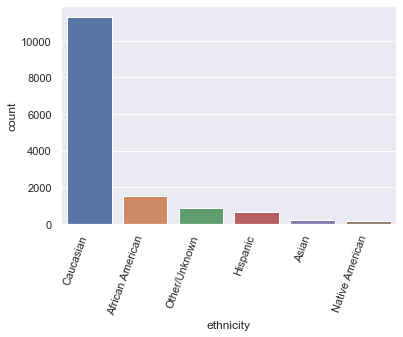

In [38]:
# Imputing values for ethnicity
X_cat.loc[:, 'ethnicity'] = X_cat['ethnicity'].fillna('Other/Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['ethnicity'], order = X_cat['ethnicity'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [40]:
# Percentage of gender classes
X_cat['gender'].value_counts(normalize=True)

M    0.540602
F    0.459398
Name: gender, dtype: float64

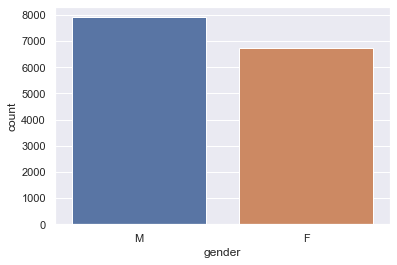

In [42]:
# Imputing values for gender
np.random.seed(0)
X_cat.loc[:, 'gender'] = X_cat['gender'].fillna(pd.Series(np.random.choice(['M', 'F'], 
                                                      p=[0.54, 0.46], size=len(X_cat))))
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

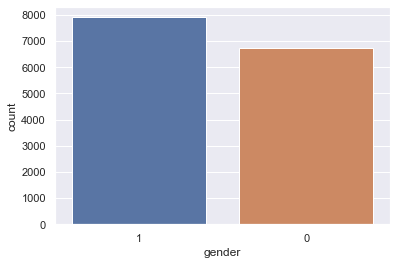

In [45]:
# Encoding gender as 1 and 0
X_cat.loc[:, 'gender'] = X_cat['gender'].replace({'F': 0, 'M': 1})
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['gender'], order = X_cat['gender'].value_counts().index)
plt.show()

In [46]:
# Comparing unequal values of hospital_admit_source and icu_admit_source
X_cat[X_cat['hospital_admit_source']!=X_cat['icu_admit_source']]

,bmi,elective_surgery,ethnicity,gender,hospital_admit_source,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,Obese,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Cardiac ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
1,Overweight,0,Caucasian,1,NaN,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
2,Overweight,0,African American,1,NaN,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,Overweight,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
5,Overweight,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,CCU-CTICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
6,Overweight,0,Caucasian,1,Emergency Department,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
7,Normal Weight,0,Caucasian,1,Emergency Department,Accident & Emergency,transfer,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
8,Obese,0,Caucasian,0,Direct Admit,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
10,Normal Weight,1,Caucasian,0,Recovery Room,Operating Room / Recovery,admit,SICU,Range[1 to 5],1,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal
11,Overweight,0,Caucasian,1,Acute Care/Floor,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal


In [50]:
# Dropping hospital_admit_source and imputing missing values for icu_admit_source
X_cat = X_cat.drop(columns = 'hospital_admit_source', axis=1)
X_cat.loc[:, 'icu_admit_source'] = X_cat['icu_admit_source'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['icu_admit_source'], order = X_cat['icu_admit_source'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

KeyError: "['hospital_admit_source'] not found in axis"

In [48]:
# Comparing unequal values of apache_3j_bodysystem and apache_2_bodysystem
X_cat[X_cat['apache_3j_bodysystem']!=X_cat['apache_2_bodysystem']]

,bmi,elective_surgery,ethnicity,gender,icu_admit_source,icu_stay_type,icu_type,pre_icu_los_days,apache_post_operative,arf_apache,gcs_unable_apache,intubated_apache,ventilated_apache,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
6,Overweight,0,Caucasian,1,Accident & Emergency,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
9,Normal Weight,0,Caucasian,0,Floor,transfer,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
12,Overweight,0,Caucasian,0,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
17,Obese,0,Caucasian,0,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
19,Obese,0,Hispanic,0,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
21,Normal Weight,0,Caucasian,1,Floor,admit,Med-Surg ICU,Range[1 to 5],0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
23,Obese,0,African American,0,Accident & Emergency,admit,SICU,Range[1 to 5],0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
25,Normal Weight,0,Caucasian,1,Other Hospital,admit,Med-Surg ICU,Range[- to 0],0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
26,Obese,1,Hispanic,0,Operating Room / Recovery,admit,Med-Surg ICU,Range[1 to 5],1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Musculoskeletal/Skin,Undefined diagnoses
33,Underweight,0,Caucasian,0,Accident & Emergency,admit,MICU,Range[1 to 5],0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular


[Text(0, 0, 'Cardiovascular'),
 Text(0, 0, 'Sepsis'),
 Text(0, 0, 'Respiratory'),
 Text(0, 0, 'Neurological'),
 Text(0, 0, 'Gastrointestinal'),
 Text(0, 0, 'Metabolic'),
 Text(0, 0, 'Trauma'),
 Text(0, 0, 'Genitourinary'),
 Text(0, 0, 'Unknown'),
 Text(0, 0, 'Musculoskeletal/Skin'),
 Text(0, 0, 'Hematological'),
 Text(0, 0, 'Gynecological')]

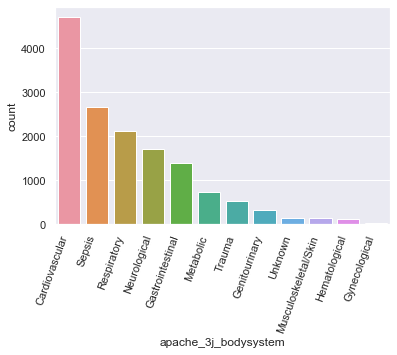

In [49]:
# Dropping apache_2_bodysystem and imputing missing values for apache_3j_bodysystem
X_cat = X_cat.drop(columns = 'apache_2_bodysystem', axis=1)
X_cat.loc[:, 'apache_3j_bodysystem'] = X_cat['apache_3j_bodysystem'].fillna('Unknown')
sns.set(style="darkgrid")
ax = sns.countplot(X_cat['apache_3j_bodysystem'], order = X_cat['apache_3j_bodysystem'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
plt.show()

In [51]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                     59
gcs_unable_apache              89
intubated_apache               59
ventilated_apache              59
aids                           59
cirrhosis                      59
diabetes_mellitus              59
hepatic_failure                59
immunosuppression              59
leukemia                       59
lymphoma                       59
solid_tumor_with_metastasis    59
apache_3j_bodysystem            0
dtype: int64

In [52]:
# Obtaining the index values of rows where arf_apache is NaN
idx = X_cat.index[X_cat['arf_apache'].isnull()].tolist()

# Dropping rows from X_cat
X_cat = X_cat.drop(X_cat.index[idx]).reset_index(drop=True)
print("The shape of X_cat after dropping rows is {}".format(X_cat.shape))

# Dropping rows from X_num
X_num = final_X[num_col]
X_num = X_num.drop(X_num.index[idx]).reset_index(drop=True)
print("The shape of X_num after dropping rows is {}".format(X_num.shape))

# Dropping corresponding rows from y
final_y = final_y.drop(final_y.index[idx]).reset_index(drop=True)
print("The shape of y after dropping rows is {}".format(final_y.shape))

The shape of X_cat after dropping rows is (14577, 22)
The shape of X_num after dropping rows is (14577, 118)
The shape of y after dropping rows is (14577,)


In [53]:
X_cat.isnull().sum()

bmi                             0
elective_surgery                0
ethnicity                       0
gender                          0
icu_admit_source                0
icu_stay_type                   0
icu_type                        0
pre_icu_los_days                0
apache_post_operative           0
arf_apache                      0
gcs_unable_apache              30
intubated_apache                0
ventilated_apache               0
aids                            0
cirrhosis                       0
diabetes_mellitus               0
hepatic_failure                 0
immunosuppression               0
leukemia                        0
lymphoma                        0
solid_tumor_with_metastasis     0
apache_3j_bodysystem            0
dtype: int64

In [54]:
# Dropping gcs_unable_apache
X_cat = X_cat.drop(columns = 'gcs_unable_apache', axis=1)
X_cat.isnull().sum()

bmi                            0
elective_surgery               0
ethnicity                      0
gender                         0
icu_admit_source               0
icu_stay_type                  0
icu_type                       0
pre_icu_los_days               0
apache_post_operative          0
arf_apache                     0
intubated_apache               0
ventilated_apache              0
aids                           0
cirrhosis                      0
diabetes_mellitus              0
hepatic_failure                0
immunosuppression              0
leukemia                       0
lymphoma                       0
solid_tumor_with_metastasis    0
apache_3j_bodysystem           0
dtype: int64

### Dealing with numerical variables

In [56]:
X_num.shape

(14577, 118)